<a href="https://colab.research.google.com/github/Wonmi2/AI_intermediate/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 크롤러

네이버랑 구글 모두 사진가져오는게 막혀서 진행이 안됨.........

In [ ]:
from urllib.request import urlopen
from urllib.parse import quote_plus
from bs4 import BeautifulSoup # 클래스 : html파싱(변환을 해주는..)을 하는 클래스

# 네이버 검색
# baseUrl = "https://search.naver.com/search.naver?where=image&sm=tab_jum&query="
# plusUrl = input('검색어 입력:')
# url = baseUrl + quote_plus(plusUrl)

# 구글 검색
url = "https://www.google.com/search?q=%EA%B0%80%EC%88%98+%EC%9D%B4%EC%8A%B9%EC%9C%A4&tbm=isch&ved=2ahUKEwiVrZSJ0s7yAhVayZQKHV5RAG8Q2-cCegQIABAA&oq=%EA%B0%80%EC%88%98+%EC%9D%B4%EC%8A%B9%EC%9C%A4&gs_lcp=CgNpbWcQA1AAWABgl-CgA2gAcAB4AIABAIgBAJIBAJgBAKoBC2d3cy13aXotaW1n&sclient=img&ei=o4InYdXPJdqS0wTeooH4Bg&bih=865&biw=1278"
# 1. 원격 서버 url 요청(urlopen(가져올 url저장한 객체))
req = urlopen(url) # 요청 -> 응답한 결과를 객체(req)에 저장
data = req.read() # source 읽기
# print(data) #-> 인코딩이 되지 않아 깨진한글들이 발견됨

# 2. html 파싱 : source -> html로 문서 변환
src = data.decode('utf-8')  # charset저장된 data를 utf-8방식으로 읽겠다.=decoding/저장해서 컴퓨터가 이해하도록하는것은 encoding
html = BeautifulSoup(src, 'html.parser') # 변환기에 넣기
# print(html) # html 문서가 되었음
img = html.find_all(class_='<img src', limit=50)

n=1
for i in img:
  imgUrl = i['data-source']
  with urlopen(imgUrl) as f:
    with open('/content/drive/MyDrive/project_picture/' + '이승윤' + srt(n)+'.jpg','wb') as h:
      img = f.read()
      h.write(img)
  n += 1
print('다운로드 완료')


HTTPError: ignored

# 실습 : 이미지 한개만 불러오기

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# 구글 드라이브로 경로 지정
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


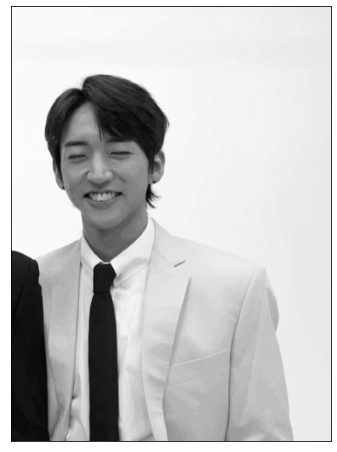

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/project_picture/A (15).jpg')
# print(image)

# 흑백이미지 만들기
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 흑백이미지 그리기
plt.figure(figsize=(12,8))
plt.imshow(grayImage, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

(1, 4)
얼굴 개수: 1


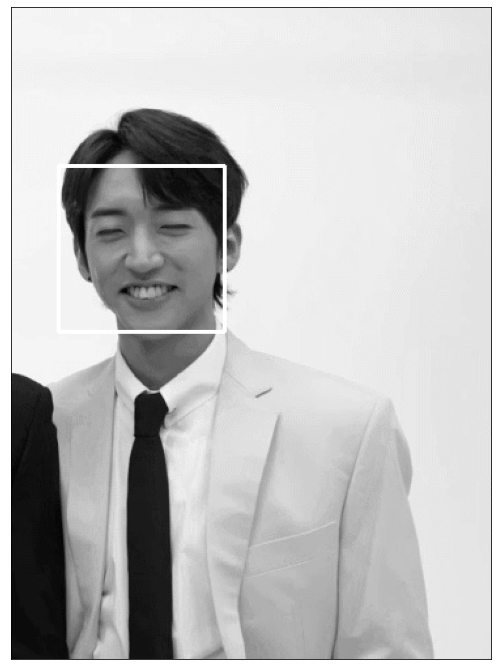

In [ ]:
# 얼굴 찾기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(grayImage, 1.3, 5)
print(faces.shape)
print("얼굴 개수: " + str(faces.shape[0]))

# 사진 상에서 얼굴이 어디인지 찾기
faces

for (x,y,w,h) in faces:
    cv2.rectangle(grayImage,(x,y),(x+w,y+h),(255,0,0),2)
plt.figure(figsize=(12,12))
plt.imshow(grayImage, cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# 전체 사진 불러오기

코드를 어떻게 짜야할지 막막해서 일단 패스..

In [ ]:
for i in range(81):
  image = cv2.imread('/content/drive/MyDrive/project_picture/A (i).jpg')
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayImage)

error: ignored

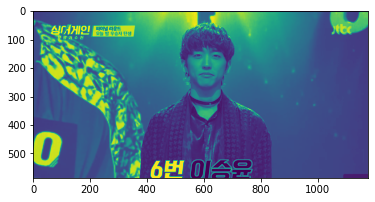

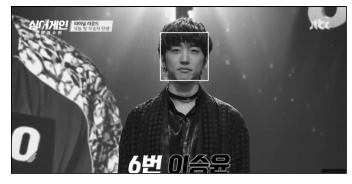

In [ ]:
# 이미지 불러오기

image = cv2.imread('/content/drive/MyDrive/project_picture/A (5).jpg')
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayImage)

# 얼굴 찾기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(grayImage, 1.3, 5)

for (x,y,w,h) in faces:
  cv2.rectangle(grayImage,(x,y),(x+w,y+h),(255,0,0),2)
plt.figure(figsize=(6,6))
plt.imshow(grayImage, cmap='gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

#사용할 모델 : CNN

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# 데이터 읽기

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
print(x_train.shape)
print(t_train.shape)